In [2]:
!pip install pyxdf
!pip install mne
!pip install pandas
!pip install --upgrade jupyterlab ipympl ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 8.6 MB/s  0:00:01 eta 0:00:01
  Attempting uninstall: jupyterlab
    Found existing installation: jupyterlab 4.4.9
    Uninstalling jupyterlab-4.4.9:
      Successfully uninstalled jupyterlab-4.4.9


In [3]:
import sys
print(sys.version)

3.11.13 (main, Sep 22 2025, 18:50:24) [Clang 17.0.0 (clang-1700.0.13.5)]


In [4]:
import pyxdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import mne
import pandas as pd
import os

In [67]:
# csv_data = pd.read_csv('data/luka_ern_lrp.csv')
csv_data = pd.read_csv('data/nani_ern_lrp.csv')
csv_data.head()

,timestamp_iso,global_trial,block,trial_in_block,stimulus,center_dir,congruent,correct_key,resp_key,correct,rt_ms,stim_time_s,isi_s
0,2025-10-03T07:23:57.391,1,1,1,>>>>>,>,1,slash,slash,1,583.55,0.2,1.207
1,2025-10-03T07:23:59.273,2,1,2,<<><<,>,0,slash,lshift,0,583.75,0.2,1.311
2,2025-10-03T07:24:01.121,3,1,3,>><>>,<,0,lshift,lshift,1,583.50,0.2,1.344
3,2025-10-03T07:24:03.036,4,1,4,<<<<<,<,1,lshift,lshift,1,499.33,0.2,1.213
4,2025-10-03T07:24:04.902,5,1,5,>>>>>,>,1,slash,slash,1,500.28,0.2,1.297


In [68]:
# We need this for ERN
correct_idx = csv_data[csv_data['correct'] == 1].index.values
incorrect_idx = csv_data[csv_data['correct'] == 0].index.values
print(f"Correct trials count: {len(correct_idx)}")
print(f"Incorrect trials count: {len(incorrect_idx)}")

Correct trials count: 519
Incorrect trials count: 81


In [69]:
# We need this for LRP
right_hand = csv_data[csv_data['resp_key'] == 'slash'].index.values
left_hand = csv_data[csv_data['resp_key'] == 'lshift'].index.values
print(f"Left hand responses count: {len(left_hand)}")
print(f"Right hand responses count: {len(right_hand)}")

Left hand responses count: 277
Right hand responses count: 323


In [70]:
# We need this for LRP
compatible = csv_data[csv_data['congruent'] == 1].index.values
incompatible = csv_data[csv_data['congruent'] == 0].index.values
print(f"Compatible hand responses count: {len(compatible)}")
print(f"Incompatible hand responses count: {len(incompatible)}")

Compatible hand responses count: 300
Incompatible hand responses count: 300


In [71]:
# For LRP, we often choose only correct responses and contrast left/right hand responses there
right_correct = np.intersect1d(correct_idx, right_hand)
left_correct = np.intersect1d(correct_idx, left_hand)
print(f"Left hand correct responses count: {len(left_correct)}")
print(f"Right hand correct responses count: {len(right_correct)}")

Left hand correct responses count: 242
Right hand correct responses count: 277


In [72]:
# We could also see compatible vs incompatible bins
compatible_right_correct = np.intersect1d(right_correct, compatible)
incompatible_right_correct = np.intersect1d(right_correct, incompatible)
compatible_left_correct = np.intersect1d(left_correct, compatible)
incompatible_left_correct = np.intersect1d(left_correct, incompatible)

In [73]:
correct_idx, incorrect_idx

(array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  52,  53,  54,  56,  57,
         60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  71,  72,  74,
         75,  77,  78,  79,  80,  82,  84,  86,  88,  89,  91,  94,  95,
         96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
        110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135,
        136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148,
        149, 151, 152, 153, 155, 156, 157, 158, 159, 160, 161, 164, 165,
        166, 168, 170, 172, 173, 174, 175, 177, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 191, 192, 193, 194, 195, 197, 199,
        200, 201, 202, 203, 204, 205, 206, 207, 208

In [74]:
xdf_path = './data/nani_ern_lrp.xdf'
xdf_data = pyxdf.load_xdf(xdf_path)[0]
markers = xdf_data[1]
eeg = xdf_data[0]

In [75]:
# Redefine for Luka's data
# xdf_path = './data/luka_ern_lrp.xdf'
# xdf_data = pyxdf.load_xdf(xdf_path)[0]
# markers = xdf_data[1]
# eeg = xdf_data[0]

In [76]:
# Read marker data
marker_time = markers['time_stamps']
time_offset = marker_time[0]
marker_time = marker_time - time_offset
marker_data = [x[0] for x in markers['time_series']]

In [77]:
# n400_data = ExperimentData('data/nani_n400.xdf')

In [78]:
CONST_OFFSET = 0.073  # Delay measured with photodiode that day

In [79]:
eeg_time = eeg['time_stamps']
eeg_time = eeg_time - time_offset - CONST_OFFSET
eeg_data = eeg['time_series'][:, :8]

In [80]:
# Create raw data
info = mne.create_info(ch_names=['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8'], ch_types=['eeg'] * 8,
                       sfreq=250)
raw = mne.io.RawArray([1e-6 * eeg_data[:, i] for i in range(8)], info)
raw.notch_filter(freqs=[50])
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)  # Set montage (Helps plot evokeds with colors)
raw.filter(0.5, 30)
raw

Creating RawArray with float64 data, n_channels=8, n_times=328175
    Range : 0 ... 328174 =      0.000 ...  1312.696 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband a

<RawArray | 8 x 328175 (1312.7 s), ~20.0 MiB, data loaded>

In [81]:
MARKER_STIM_ONSET = 1
MARKER_RESP = 2

In [82]:
events = []
for i, marker in enumerate(marker_data):
    eeg_start_index = np.argmax(eeg_time >= marker_time[i]) - 1
    events.append([eeg_start_index, 0, marker])
events = np.array(events)

# ERN
- Expected result: The ERN was a more negative voltage over midline frontocentral cortex **(FCz)** for incorrect responses compared to correct responses.

Since we have no FCz electrode, we take the mean of Fz and Cz electrodes.

In [83]:
picks = ["Fz", "Cz"]
event_dict_stim = dict(marker=1)
event_dict_resp = dict(marker=2)
tmin, tmax = -0.2, 1
epochs = mne.Epochs(raw, events, event_id=event_dict_stim, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks)
resp_epochs = mne.Epochs(raw, events, event_id=event_dict_resp, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks)

Not setting metadata
601 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 601 events and 301 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1 events and 301 original time points ...
0 bad epochs dropped


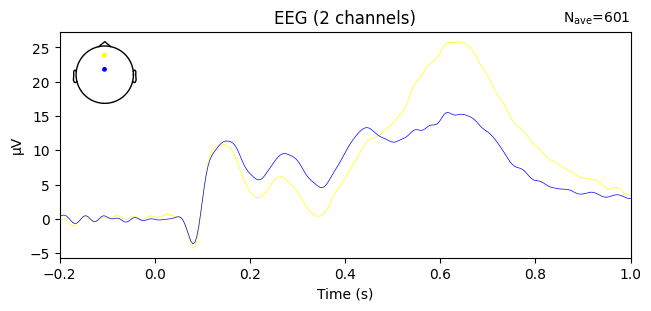

In [84]:
epochs.average().plot(picks=picks)
plt.show()

combining channels using "mean"


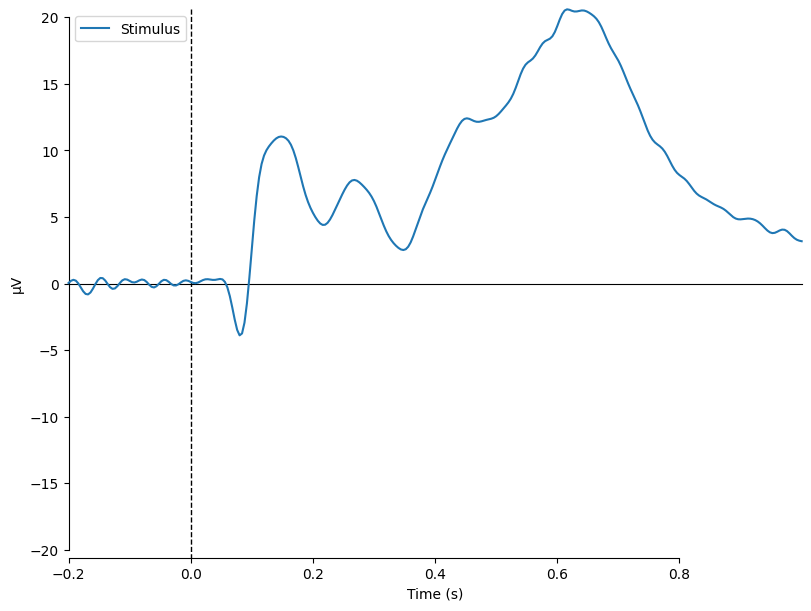

[<Figure size 800x600 with 1 Axes>]

In [85]:
mne.viz.plot_compare_evokeds(
    {"Stimulus": epochs['marker'].average()},
    combine='mean',
    show=True
)

In [86]:
correct_epochs = epochs[correct_idx]
incorrect_epochs = epochs[incorrect_idx]

In [87]:
avg_response_time = csv_data['rt_ms'].median()  # We use median because we have one large outlier
print(f"Average response time: {avg_response_time}")

Average response time: 400.935


combining channels using "mean"
combining channels using "mean"


/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_7306/2924072262.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


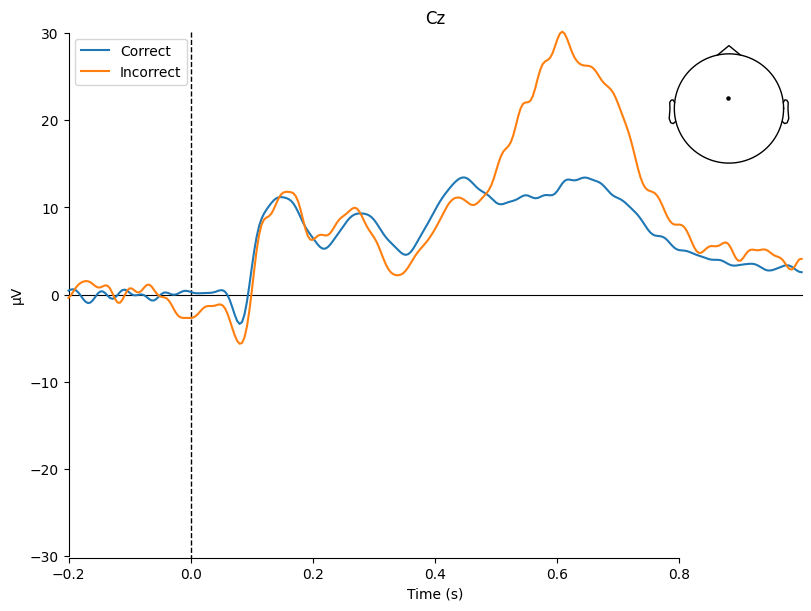

[<Figure size 800x600 with 2 Axes>]

In [97]:
mne.viz.plot_compare_evokeds(
    {"Correct": correct_epochs.average(), "Incorrect": incorrect_epochs.average()},
    picks="Cz",
    combine='mean',
    show=True
)

combining channels using "mean"


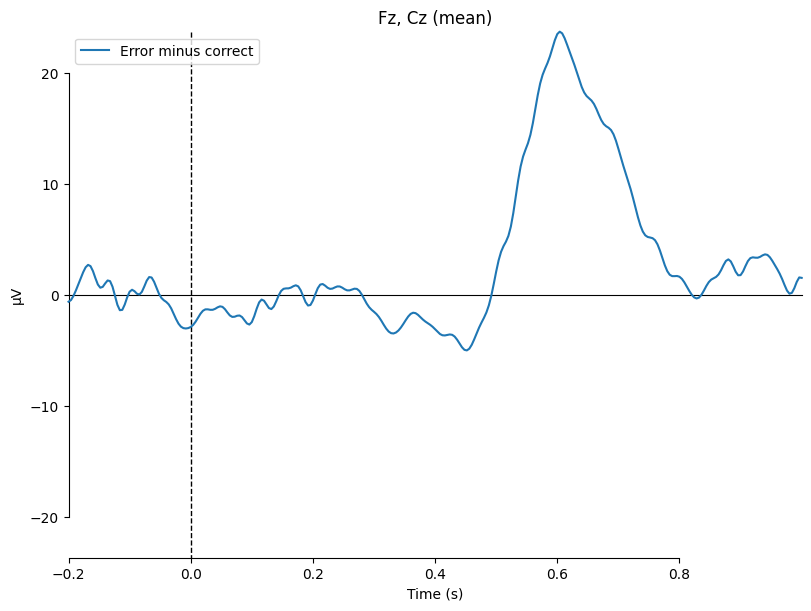

[<Figure size 800x600 with 1 Axes>]

In [93]:
mne.viz.plot_compare_evokeds(
    {"Error minus correct": mne.combine_evoked([correct_epochs.average(), incorrect_epochs.average()], weights=[-1, 1])},
    # {"Left hand": left_epochs.average()},
    picks=["Fz", "Cz"],
    combine='mean',
    show=True
)

## LRP
Deriving the LRP during the analysis (Eimer & Coles, [2003](https://link.springer.com/chapter/10.1007/978-1-4615-0189-3_14)):
- ERP data are available for an epoch that begins 100 ms before the imperative stimulus for 600 ms post-stimulus. 
- The first stage in the analysis is to sort trials into two groups: those for which the left hand response is correct and those for which the right hand response is correct. 
- Then, ERP data from two lateral electrodes placed over the left and right motor cortices (C3 and C4, respectively) are averaged separately for the two groups of trials. 
- These averages are characterised by: 
    - (a) a general positive response in all waveforms;
    - (b) an asymmetry between the averages for C3 and C4 which begins between 150 and 200 IDS post stimulus;
    - (c) for left-hand responses the voltage at C4 is more negative than that at C3;
    - (d) the converse is the case for right hand responses.
- These lateralized negativities are isolated in the next step of the procedure which involves subtracting the voltage recorded at C4 from that recorded at C3. These difference waveforms reflect the asymmetrical activity associated with left and right-hand movements. 
- The third step in the procedure involves a second subtraction: the asymmetry waveform for right-hand responses is subtracted from the asymmetry waveform for left-hand responses.
- If lateralized negativities are larger over the contralateral than the ipsilateral hemisphere, this double subtraction isolates the lateralized readiness potential (LRP), providing a clean measure of motor preparation independent of general stimulus-evoked activity.

In [94]:
picks = ["C3", "C4"]
event_dict_stim = dict(marker=1)
# Since we have no response markers we use stimulus markers,
# but, we construct the epochs around mean response time
tmin, tmax = -0.1, 1
epochs = mne.Epochs(raw, events, event_id=event_dict_stim, tmin=tmin, tmax=tmax, preload=True,
                    baseline=(None, 0 if tmin < 0 else None), picks=picks)

Not setting metadata
601 matching events found
Setting baseline interval to [-0.1, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 601 events and 276 original time points ...
0 bad epochs dropped


In [29]:
left_epochs = epochs[left_correct]
right_epochs = epochs[right_correct]

combining channels using "mean"
combining channels using "mean"


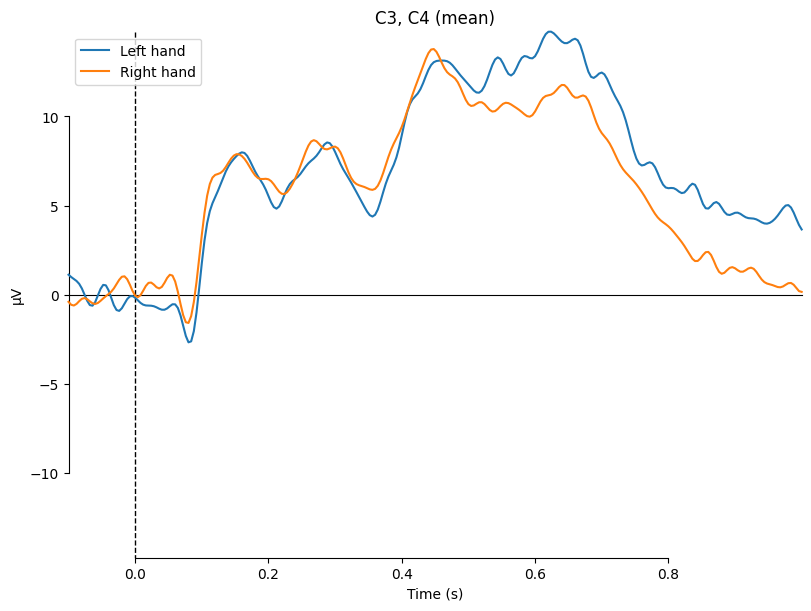

[<Figure size 800x600 with 1 Axes>]

In [30]:
mne.viz.plot_compare_evokeds(
    {"Left hand": left_epochs.average(), "Right hand": right_epochs.average()},
    # {"Left hand": left_epochs.average()},
    picks=["C3", "C4"],
    combine='mean',
    show=True
)

# Left hand epochs

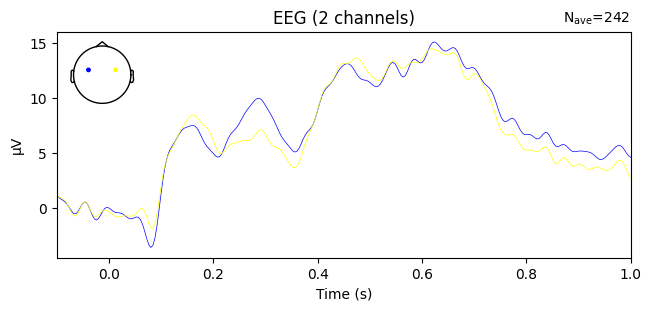

In [31]:
left_epochs.average().plot(picks=picks)
plt.show()

# Right hand epochs

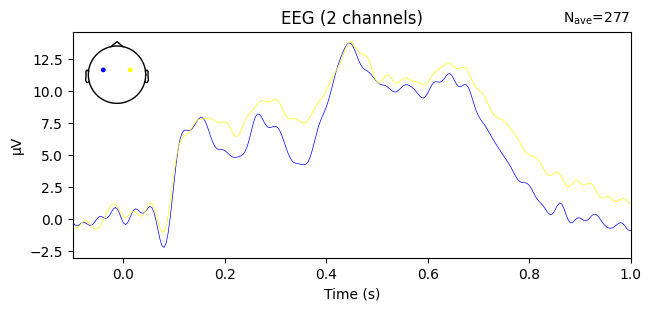

In [32]:
right_epochs.average().plot(picks=picks)
plt.show()

# C3 - C4

EEG channel type selected for re-referencing
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
EEG channel type selected for re-referencing
Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
combining channels using "mean"
combining channels using "mean"


/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_7306/539025644.py:15: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


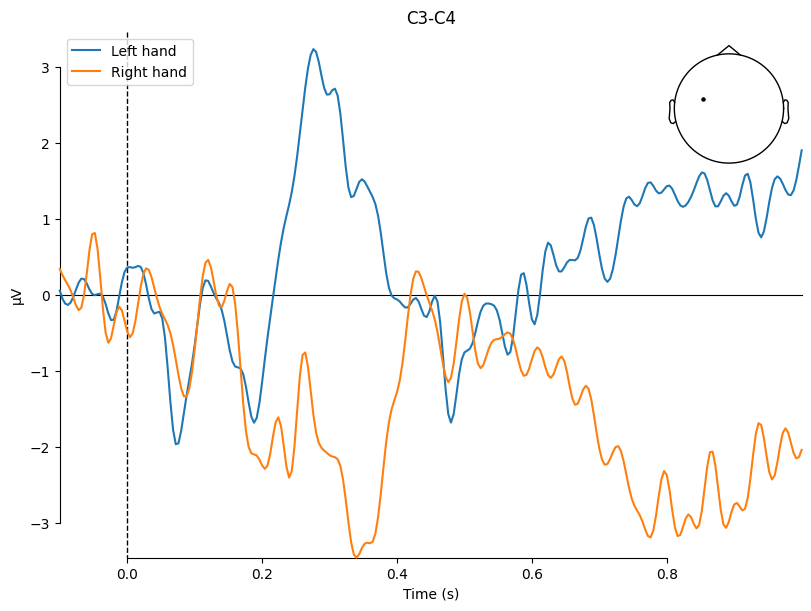

[<Figure size 800x600 with 2 Axes>]

In [33]:
# make a new channel C3-C4 = C3 - C4 (keep originals too)
left_epochs_bip = mne.set_bipolar_reference(
    left_epochs, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)
right_epochs_bip = mne.set_bipolar_reference(
    right_epochs, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)

# now average just that derived channel
left_evk_diff = left_epochs_bip.average(picks='C3-C4')
right_evk_diff = right_epochs_bip.average(picks='C3-C4')

mne.viz.plot_compare_evokeds(
    {"Left hand": left_evk_diff, "Right hand": right_evk_diff},
    # {"Left hand": left_epochs.average()},
    picks=["C3-C4"],
    combine='mean',
    show=True
)

Need more than one channel to make topography for eeg. Disabling interactivity.


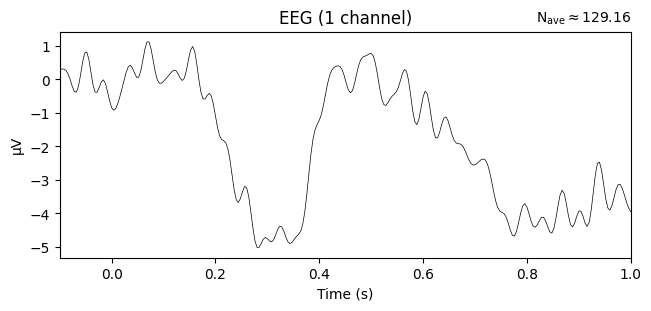

In [34]:
mne.combine_evoked([left_evk_diff, right_evk_diff], weights=[-1, 1]).plot()
plt.show()

# Compatible vs Incompatible

In [35]:
left_compatible = epochs[compatible_left_correct]
right_compatible = epochs[compatible_right_correct]
left_incompatible = epochs[incompatible_left_correct]
right_incompatible = epochs[incompatible_right_correct]

EEG channel type selected for re-referencing
Not setting metadata
141 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
EEG channel type selected for re-referencing
Not setting metadata
149 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
EEG channel type selected for re-referencing
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
EEG channel type selected for re-referencing
Not setting metadata
128 matching events found
No baseline correction applied
0 projection items activated
Added the following bipolar channels:
C3-C4
combining channels using "mean"
combining channels using "mean"


/var/folders/g2/378vjvgj0vq1r9_l6pb_nbz00000gn/T/ipykernel_7306/3261953509.py:29: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(


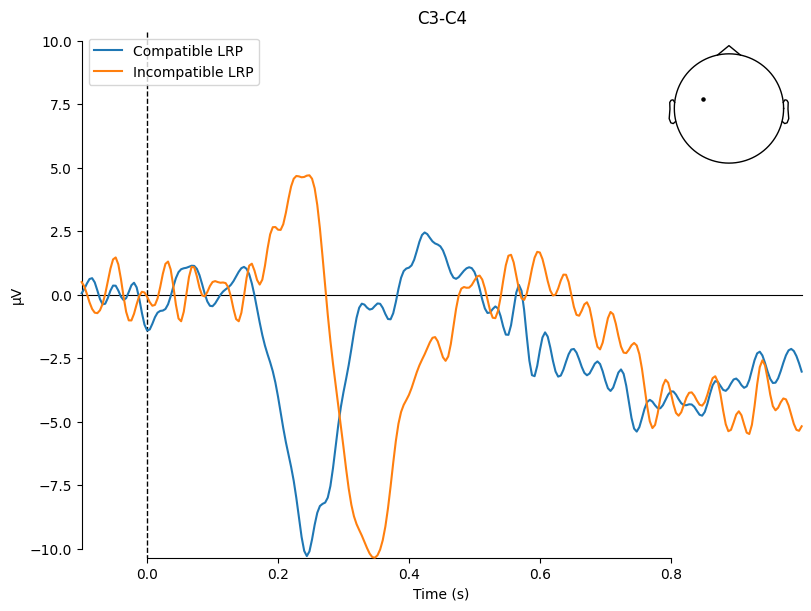

[<Figure size 800x600 with 2 Axes>]

In [37]:
# make a new channel C3-C4 = C3 - C4 (keep originals too)
left_epochs_comp = mne.set_bipolar_reference(
    left_compatible, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)
right_epochs_comp = mne.set_bipolar_reference(
    right_compatible, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)

left_epochs_incomp = mne.set_bipolar_reference(
    left_incompatible, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)
right_epochs_incomp = mne.set_bipolar_reference(
    right_incompatible, anode='C3', cathode='C4',
    ch_name='C3-C4', drop_refs=False, copy=True
)

# now average just that derived channel
left_comp_diff = left_epochs_comp.average(picks='C3-C4')
right_comp_diff = right_epochs_comp.average(picks='C3-C4')
left_incomp_diff = left_epochs_incomp.average(picks='C3-C4')
right_incomp_diff = right_epochs_incomp.average(picks='C3-C4')

comp_lrp = mne.combine_evoked([left_comp_diff, right_comp_diff], weights=[-1, 1])
incomp_lrp = mne.combine_evoked([left_incomp_diff, right_incomp_diff], weights=[-1, 1])

mne.viz.plot_compare_evokeds(
    {"Compatible LRP": comp_lrp, "Incompatible LRP": incomp_lrp},
    # {"Left hand": left_epochs.average()},
    picks=["C3-C4"],
    combine='mean',
    show=True
)